### Wstęp i nawigacja
Poniższy notebook przedstawia kompletny proces budowy modelu oceny ryzyka kredytowego (Credit Scoring) – od analizy danych (EDA), przez inżynierię cech, aż po trenowanie modeli XGBoost, CatBoost, LightGBM oraz ich ensemblingów a następnie ewaluację. 

Ze względu na złożoność procesu, szczegółowe podsumowanie , interpretację wyników oraz uzasadnienie decyzji projektowych zamieściłem na samym końcu tego dokumentu. Zapraszam do zapoznania się z kodem, a następnie z sekcją "Podsumowanie i Wnioski".

In [1]:
# import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import optuna
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap

# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    roc_auc_score, roc_curve, recall_score, precision_score, 
    accuracy_score, f1_score, confusion_matrix
)


warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [23]:
df_train = pd.read_parquet("train.parquet")
df_test = pd.read_parquet("test.parquet")


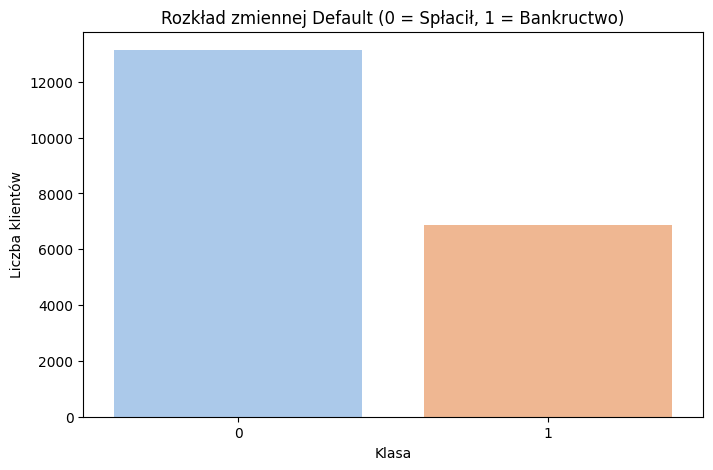

In [4]:
# Rozkład zmiennej celu
plt.figure(figsize=(8, 5))
sns.countplot(x=df_train['Default'], palette='pastel')
plt.title('Rozkład zmiennej Default (0 = Spłacił, 1 = Bankructwo)')
plt.xlabel('Klasa')
plt.ylabel('Liczba klientów')
plt.show()

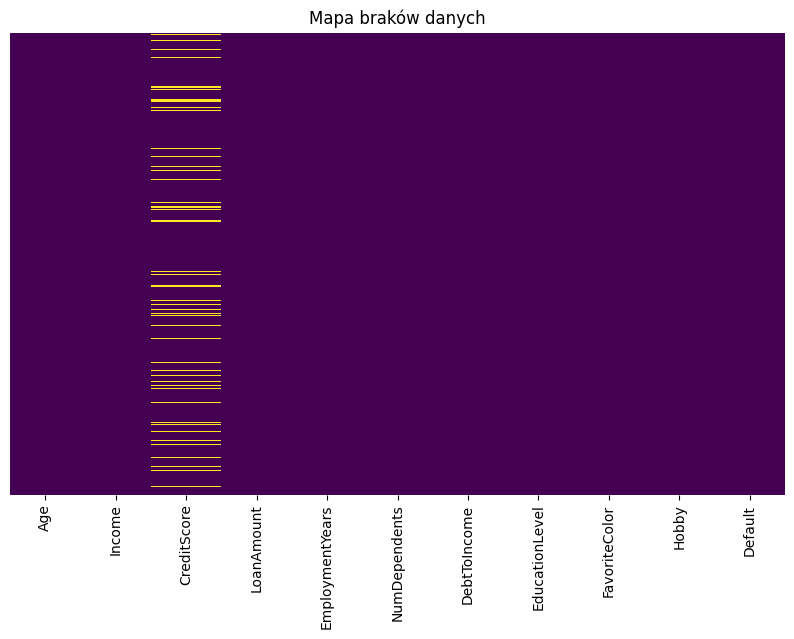

In [5]:
# Braki danych
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Mapa braków danych')
plt.show()

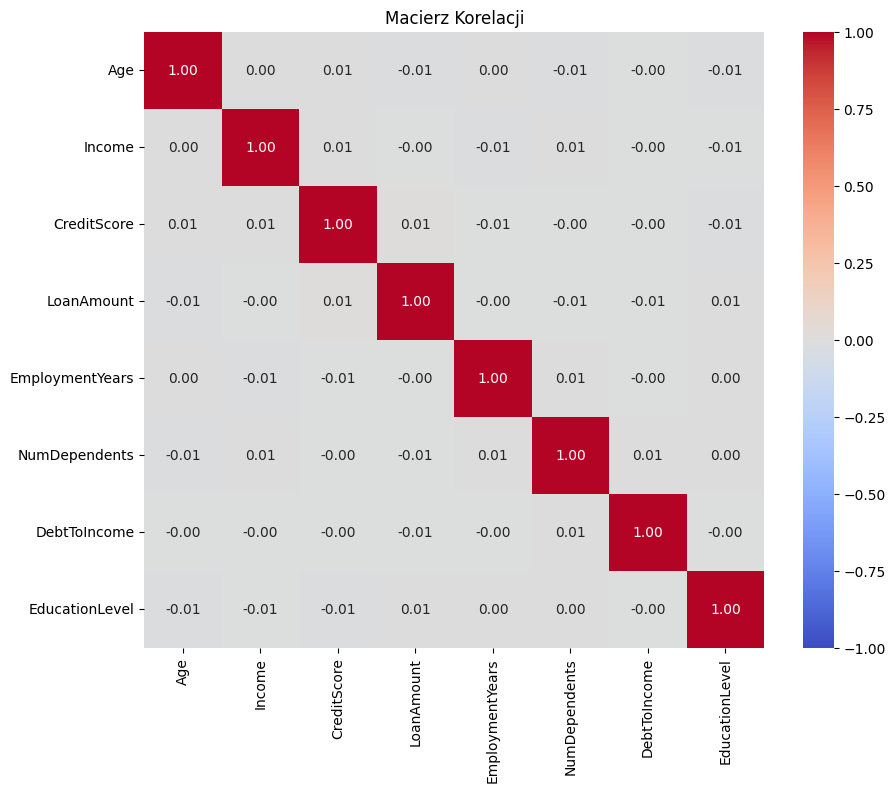

In [6]:
# Korelacje zmiennych numerycznych

numeric_eda = df_train.select_dtypes(include=[np.number]).drop('Default', axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_eda.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz Korelacji')
plt.show()


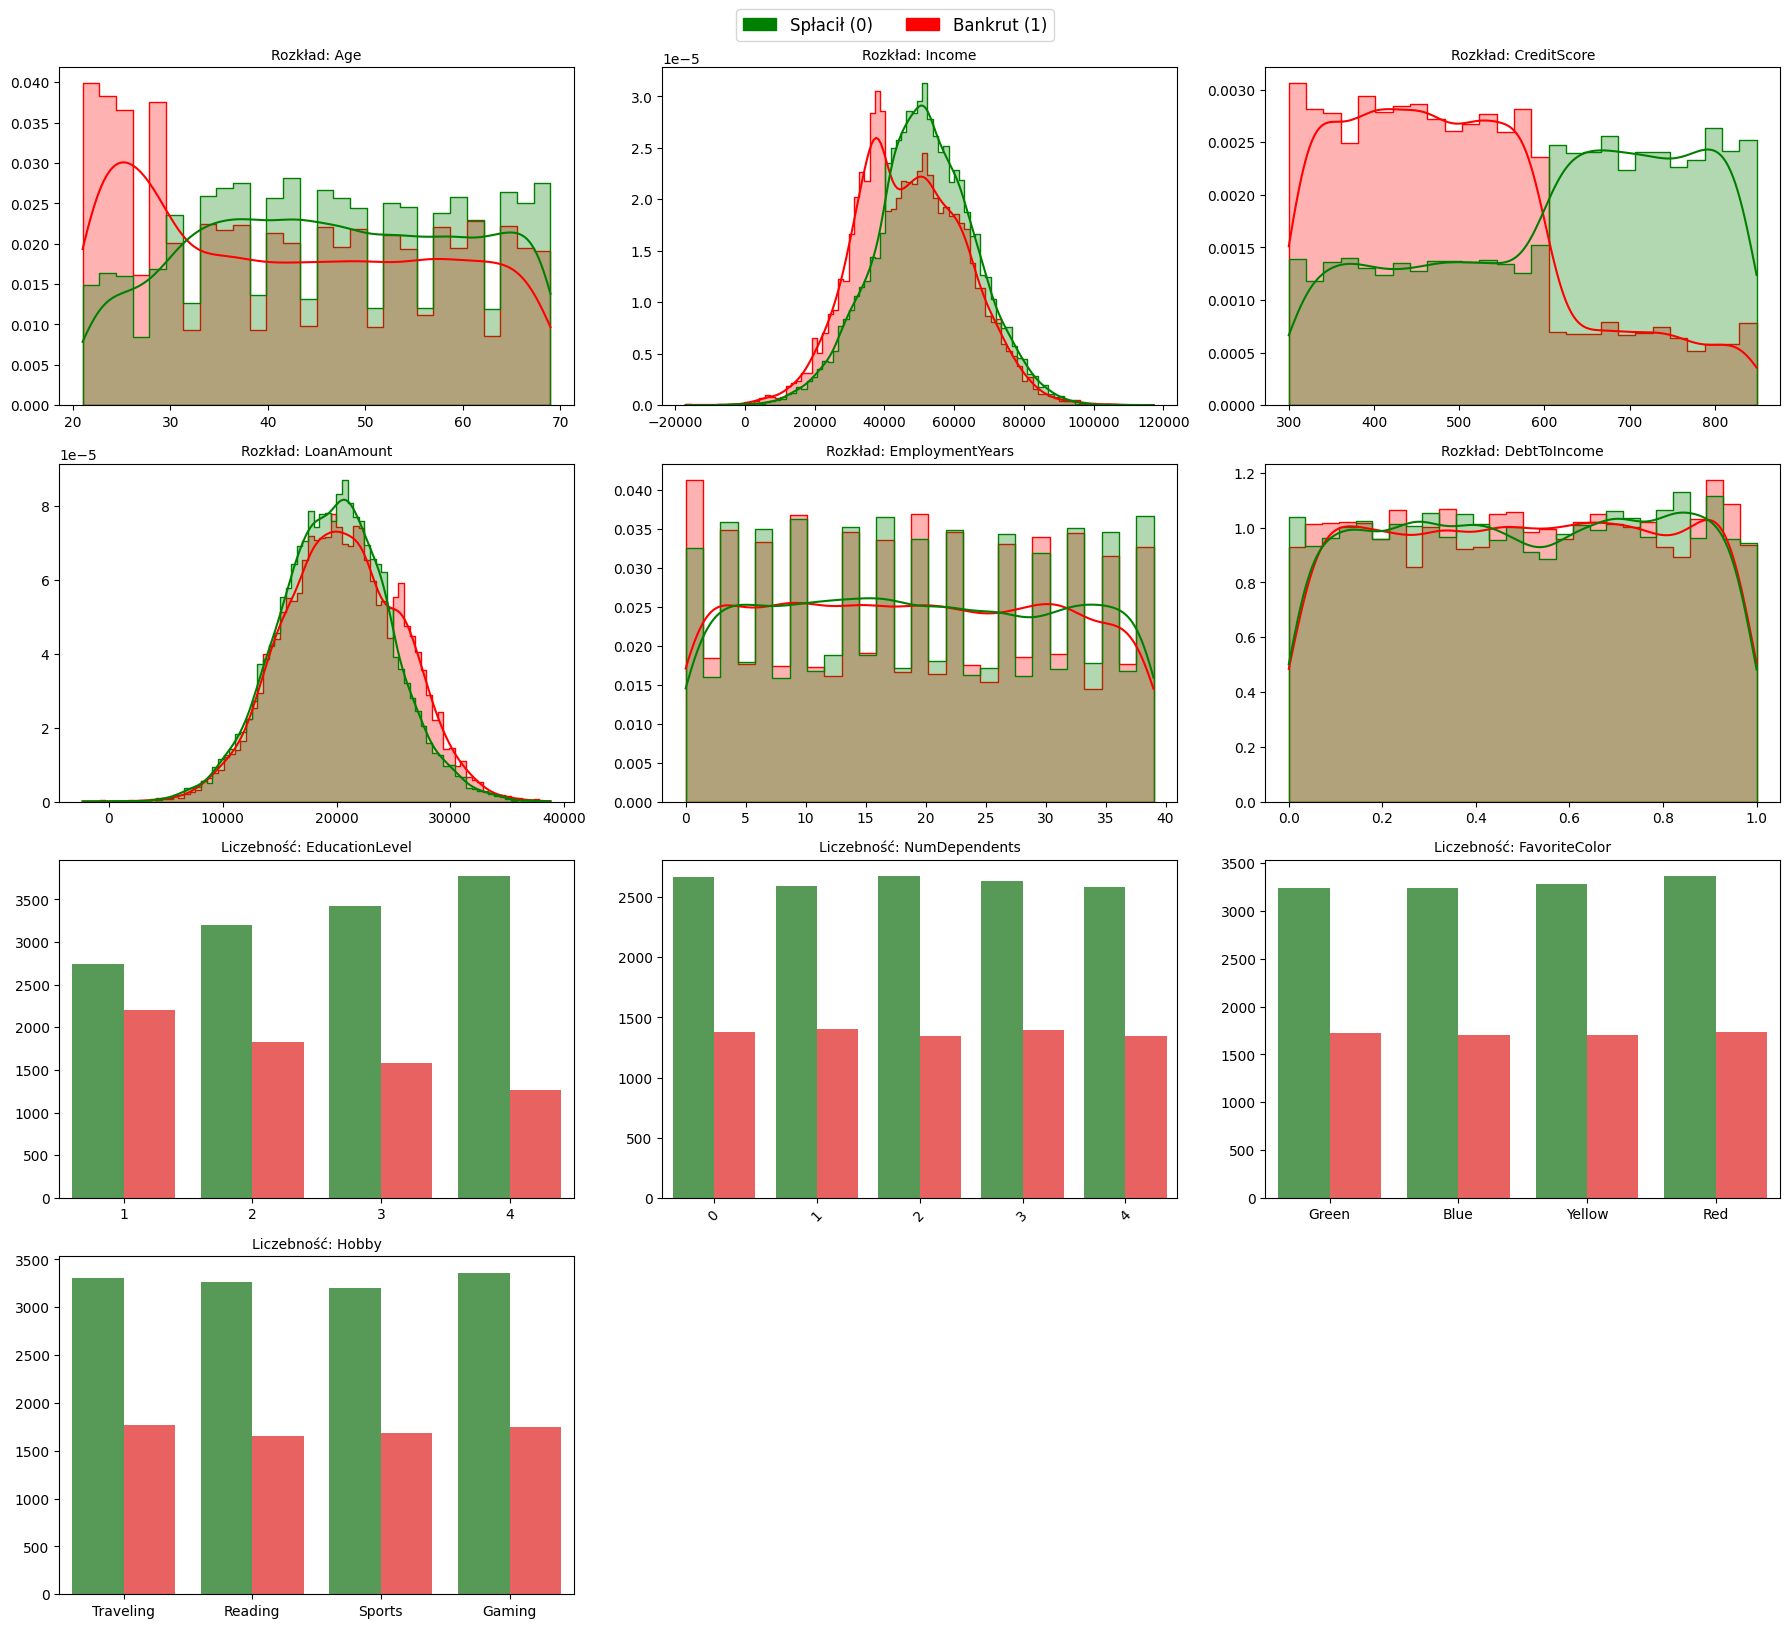

In [7]:
# 1. Definicja zmiennych
cat_vars_eda = ['EducationLevel', 'NumDependents', 'FavoriteColor', 'Hobby']
cont_vars_eda = ['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears', 'DebtToIncome']

# Łączymy listy (najpierw ciągłe, potem kategoryczne dla porządku)
all_vars_eda = cont_vars_eda + cat_vars_eda

# Ustawienia siatki
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten() # Spłaszczamy tablicę osi, żeby łatwo po niej iterować

# Pętla rysująca
for i, col in enumerate(all_vars_eda):
    ax = axes[i]
    
    # Wykresy dla zmiennych ciągłych
    if col in cont_vars_eda:
        sns.histplot(
            data=df_train, x=col, hue='Default', 
            kde=True, element="step", stat="density", common_norm=False,
            palette={0: 'green', 1: 'red'}, ax=ax, alpha=0.3
        )
        ax.set_title(f'Rozkład: {col}', fontsize=10)
        
    # Wykresy dla zmiennych kategorycznych
    else:
        sns.countplot(
            data=df_train, x=col, hue='Default', 
            palette={0: 'green', 1: 'red'}, ax=ax, alpha=0.7
        )
        ax.set_title(f'Liczebność: {col}', fontsize=10)
        
        if df_train[col].nunique() > 4:
            ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Usuwamy legendę z każdego małego wykresu
    if ax.get_legend():
        ax.legend_.remove()

# Usuwamy puste sloty
for j in range(len(all_vars_eda), len(axes)):
    fig.delaxes(axes[j])

# Tworzymy legendę
green_patch = mpatches.Patch(color='green', label='Spłacił (0)')
red_patch = mpatches.Patch(color='red', label='Bankrut (1)')

fig.legend(handles=[green_patch, red_patch], 
           loc='upper center', 
           ncol=2, 
           fontsize=12, 
           bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.show()

In [8]:
# Dodanie kolumny informującej o missing data
for df in [df_train, df_test]:
    df['CreditScore_Missing'] = df['CreditScore'].isna().astype(int)

In [9]:
# Ponieważ zmienne Hobby oraz FavouriteColor nie są związane z defaultem w logiczny sposób 
# należy usunąć je z df ponieważ w przypadku ich losowej korelacj mogą zaburzać jakość
# wyników. Jednak, w celu dodatkowego upewnienia się dokonuję przed modelowaniem analizy
# ważności zmiennych
    
df_analysis = df_train.copy()
df_analysis['CreditScore_Missing'] = df_analysis['CreditScore'].isna().astype(int)

cat_features = ['FavoriteColor', 'Hobby']
num_features = ['EducationLevel', 'Age', 'Income', 'LoanAmount', 'EmploymentYears', 
                'DebtToIncome', 'NumDependents', 'CreditScore', 'CreditScore_Missing']

preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), num_features),
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), 
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False)), cat_features),
)

X = df_analysis[num_features + cat_features]
y = df_analysis['Default']
X_processed = preprocessor.fit_transform(X)

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feat_{i}" for i in range(X_processed.shape[1])]

model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.1)
model_l1.fit(X_processed, y)

coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coef': model_l1.coef_[0],
    'Abs_Coef': np.abs(model_l1.coef_[0])
}).sort_values(by='Abs_Coef', ascending=False)

print("top cechy wedlug lasso:")
print(coefs[['Feature', 'Coef']].head(15))

top cechy wedlug lasso:
                             Feature      Coef
7            pipeline-1__CreditScore -0.857317
0         pipeline-1__EducationLevel -0.394408
1                    pipeline-1__Age -0.342664
2                 pipeline-1__Income -0.335348
3             pipeline-1__LoanAmount  0.177322
8    pipeline-1__CreditScore_Missing  0.055034
4        pipeline-1__EmploymentYears -0.046455
14         pipeline-2__Hobby_Reading -0.038671
12  pipeline-2__FavoriteColor_Yellow -0.028552
11     pipeline-2__FavoriteColor_Red -0.027695
6          pipeline-1__NumDependents -0.000089
5           pipeline-1__DebtToIncome  0.000000
9     pipeline-2__FavoriteColor_Blue  0.000000
10   pipeline-2__FavoriteColor_Green  0.000000
13          pipeline-2__Hobby_Gaming  0.000000


In [10]:
# Z powyżej wspomnianych powodów oraz opierając się na niewielkiej istnotności
# zmiennych color i hobby usuwamy je
for df in [df_train, df_test]:
    df.drop(columns=['Hobby', 'FavoriteColor'], inplace=True, errors='ignore')

In [12]:
# Kolumny ktore bedziemy imputowac
cols_to_impute = ['CreditScore', 'Age', 'Income', 'LoanAmount', 'EmploymentYears', 
                  'NumDependents', 'DebtToIncome', 'EducationLevel']

# Tworzenie nowych zmiennych - LoanToIncomeRatio, IncomePerPerson, MonthlyDisposable, RiskScore
def add_features(df, score_col='CreditScore'):
    # Robimy kopie zeby nie psuc oryginalu
    df = df.copy()
    eps = 1e-5
    
    df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['Income'] + eps)
    df['IncomePerPerson'] = df['Income'] / (df['NumDependents'] + 1)
    df['MonthlyDisposable'] = (df['Income'] / 12) * (1 - df['DebtToIncome'])
    
    # Risk score - zalezy od tego czy score jest imputowany czy nie
    # jesli imputowany, score_col bedzie mial pelne dane. jesli native, bedzie mial NaN
    df['RiskScore'] = df['DebtToIncome'] / (df[score_col] + 1)
    
    return df.astype('float32')

In [13]:
# Tworzymy modele xgboost, catboost i lightgbm i optymalizujemy je używając optuny

def objective_with_imputation(trial, model_name, X, y):
    # Print co 5 triali
    current_trial = trial.number + 1
    if current_trial % 5 == 0 or current_trial == 1:
        print(f"   [{model_name.upper()}] Trial {current_trial}/50...")

    # Parametry do optymalizacji
    params = {}
    if model_name == 'xgb':
        params = {
            'n_estimators': 1000, 'verbosity': 0, 'tree_method': 'hist',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0)
        }
    elif model_name == 'lgbm':
        params = {
            'n_estimators': 1000, 'verbosity': -1, 'metric': 'auc',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True)
        }
    elif model_name == 'cat':
        params = {
            'iterations': 1000, 'verbose': 0, 'eval_metric': 'AUC', 'allow_writing_files': False,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 4, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_strength': trial.suggest_float('random_strength', 0.1, 5.0)
        }

    # cv 3-foldowe wewnatrz optuny
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # imputacja danych dla każdej iteracji
        imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=5, random_state=42)
        X_tr[cols_to_impute] = imputer.fit_transform(X_tr[cols_to_impute])
        X_val[cols_to_impute] = imputer.transform(X_val[cols_to_impute])
        
        # features
        X_tr = add_features(X_tr, score_col='CreditScore')
        X_val = add_features(X_val, score_col='CreditScore')
        
        # model
        if model_name == 'xgb':
            clf = xgb.XGBClassifier(**params, early_stopping_rounds=50)
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        elif model_name == 'lgbm':
            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
        elif model_name == 'cat':
            clf = CatBoostClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
            
        preds = clf.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, preds))
        
    return np.mean(scores)

# Odpalamy optune
X_raw = df_train.drop('Default', axis=1)
y_raw = df_train['Default']

best_params_store = {}
print("\n2. start optuny (50 trials, zero leakage)... to chwile potrwa...")

for m in ['xgb', 'lgbm', 'cat']:
    print(f" -> optymalizuje {m}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_with_imputation(trial, m, X_raw, y_raw), n_trials=50)
    best_params_store[m] = study.best_params


2. start optuny (50 trials, zero leakage)... to chwile potrwa...
 -> optymalizuje xgb...
   [XGB] Trial 1/50...
   [XGB] Trial 5/50...
   [XGB] Trial 10/50...
   [XGB] Trial 15/50...
   [XGB] Trial 20/50...
   [XGB] Trial 25/50...
   [XGB] Trial 30/50...
   [XGB] Trial 35/50...
   [XGB] Trial 40/50...
   [XGB] Trial 45/50...
   [XGB] Trial 50/50...
 -> optymalizuje lgbm...
   [LGBM] Trial 1/50...
   [LGBM] Trial 5/50...
   [LGBM] Trial 10/50...
   [LGBM] Trial 15/50...
   [LGBM] Trial 20/50...
   [LGBM] Trial 25/50...
   [LGBM] Trial 30/50...
   [LGBM] Trial 35/50...
   [LGBM] Trial 40/50...
   [LGBM] Trial 45/50...
   [LGBM] Trial 50/50...
 -> optymalizuje cat...
   [CAT] Trial 1/50...
   [CAT] Trial 5/50...
   [CAT] Trial 10/50...
   [CAT] Trial 15/50...
   [CAT] Trial 20/50...
   [CAT] Trial 25/50...
   [CAT] Trial 30/50...
   [CAT] Trial 35/50...
   [CAT] Trial 40/50...
   [CAT] Trial 45/50...
   [CAT] Trial 50/50...


In [14]:
# Finalny trening najlepszych modeli z i bez imputacji danych oraz stworzenie ensembli

trained_pipelines = [] 
results_table = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scenario in ['NATIVE', 'IMPUTED']:
    
    oof_preds = {
        'xgb': np.zeros(len(X_raw)),
        'lgbm': np.zeros(len(X_raw)),
        'cat': np.zeros(len(X_raw))
    }
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_raw, y_raw)):
        X_tr, X_val = X_raw.iloc[train_idx].copy(), X_raw.iloc[val_idx].copy()
        y_tr, y_val = y_raw.iloc[train_idx], y_raw.iloc[val_idx]
        
        current_imputer = None
        
        # Native a imputed
        if scenario == 'IMPUTED':
            current_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=5, random_state=42)
            X_tr[cols_to_impute] = current_imputer.fit_transform(X_tr[cols_to_impute])
            X_val[cols_to_impute] = current_imputer.transform(X_val[cols_to_impute])
            
            X_tr = add_features(X_tr, score_col='CreditScore')
            X_val = add_features(X_val, score_col='CreditScore')
            
        else: 
            X_tr = add_features(X_tr, score_col='CreditScore')
            X_val = add_features(X_val, score_col='CreditScore')
            
        # Modele
        for m_name in ['xgb', 'lgbm', 'cat']:
            params = best_params_store[m_name]
            
            if m_name == 'xgb':
                clf = xgb.XGBClassifier(**params, n_estimators=2000, early_stopping_rounds=50)
                clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            elif m_name == 'lgbm':
                clf = lgb.LGBMClassifier(**params, n_estimators=2000)
                clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
            elif m_name == 'cat':
                clf = CatBoostClassifier(**params, iterations=2000, eval_metric='AUC', verbose=False)
                clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50)
                
            val_pred = clf.predict_proba(X_val)[:, 1]
            oof_preds[m_name][val_idx] = val_pred
            
            trained_pipelines.append({
                'scenario': scenario,
                'type': m_name,
                'model': clf,
                'imputer': current_imputer,
                'fold': fold
            })
            
    # Wyniki modeli
    for m in ['xgb', 'lgbm', 'cat']:
        auc_score = roc_auc_score(y_raw, oof_preds[m])
        results_table.append({'Scenario': scenario, 'Model': m.upper(), 'AUC': auc_score})
        
    ens_pred = (oof_preds['xgb'] + oof_preds['lgbm'] + oof_preds['cat']) / 3
    ens_auc = roc_auc_score(y_raw, ens_pred)
    results_table.append({'Scenario': scenario, 'Model': 'ENSEMBLE', 'AUC': ens_auc})
   

In [16]:
# Analiza wyników i predykcja
print("\n=== Ranking końcowy (Cross-Validation AUC) ===")
res_df = pd.DataFrame(results_table).sort_values(by='AUC', ascending=False)
print(res_df)

# Wybieramy najlepszy model na podstawie AUC
winner = res_df.iloc[0]
best_scen = winner['Scenario']
best_mod = winner['Model']
print(f"\n Wygral: {best_scen} {best_mod} (auc: {winner['AUC']:.4f})")


# Przygotowanie danych testowych
X_test_raw = df_test.drop('Default', axis=1)
final_test_preds = []

# Wybieramy odpowiednie pipelines z listy
# jesli wygral ensemble, bierzemy wszystkie 3 typy modeli z tego scenariusza
# jesli pojedynczy, to tylko ten typ
target_types = ['xgb', 'lgbm', 'cat'] if best_mod == 'ENSEMBLE' else [best_mod.lower()]

pipelines_to_run = [
    p for p in trained_pipelines 
    if p['scenario'] == best_scen and p['type'] in target_types
]

for p in pipelines_to_run:
    # kopia testu
    X_curr = X_test_raw.copy()
    
    # Imputacja (jesli trzeba)
    if p['imputer'] is not None:
        X_curr[cols_to_impute] = p['imputer'].transform(X_curr[cols_to_impute])
        
    # Features
    X_curr = add_features(X_curr, score_col='CreditScore')
    
    # Predict
    pred = p['model'].predict_proba(X_curr)[:, 1]
    final_test_preds.append(pred)

# Usredniamy wszystkie predykcje (folds + models)
avg_test_pred = np.mean(final_test_preds, axis=0)



=== Ranking końcowy (Cross-Validation AUC) ===
  Scenario     Model       AUC
3   NATIVE  ENSEMBLE  0.808741
2   NATIVE       CAT  0.808635
7  IMPUTED  ENSEMBLE  0.808439
0   NATIVE       XGB  0.808182
4  IMPUTED       XGB  0.807965
6  IMPUTED       CAT  0.807757
1   NATIVE      LGBM  0.806822
5  IMPUTED      LGBM  0.806688

 Wygral: NATIVE ENSEMBLE (auc: 0.8087)


In [ ]:
# Analiza wyników z punktu widzenia biznesu
# Pomimo tego że teoretycznie najlepszym modelem jest native ensemble, lepszym wyborem
# Będzie zastosowanie native CAT. Wyniki modeli w czołówce są praktycznie identyczne,
# A praktyczny deploy modelu bez imputacji i bez ensemblingu będzie szybszy, tańszy i
# Prostszy bez realnego wpływu na jakość modelu z powodu tak niewielkich różnic
# Ponieważ chcemy zminimalizować ryzyko defaultu, jego koszt jest dużo większy niż 
# odrzucenia dobrego klienta chcemy zmaksymalizować recall w rozsądnym zakresie

# wybieramy catboosta
best_pipeline_obj = next(p for p in trained_pipelines 
                         if p['scenario'] == 'NATIVE' and p['type'] == 'cat')

native_model = best_pipeline_obj['model']
print(f"Analizuję wyniki dla modelu: {best_pipeline_obj['type'].upper()} ({best_pipeline_obj['scenario']})")

# Przygotowanie danych i predykcja
X_test_native = X_test_raw.copy()
X_test_native = add_features(X_test_native, score_col='CreditScore')


native_probs = native_model.predict_proba(X_test_native)[:, 1]

print("-" * 65)
print(f"{'Threshold':<15} | {'Recall':<10} | {'Precision':<10} | {'Accuracy':<10}")
print("-" * 65)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

for th in thresholds:
    # Używamy native_probs zamiast avg_test_pred!
    preds_bin = (native_probs >= th).astype(int)
    
    rec = recall_score(df_test['Default'], preds_bin)
    prec = precision_score(df_test['Default'], preds_bin)
    acc = accuracy_score(df_test['Default'], preds_bin)
    
    # Oznaczamy gwiazdką rekomendowany próg 0.2
    marker = " (*)" if th == 0.2 else ""
    print(f"{th:<15.2f} | {rec:<10.2%} | {prec:<10.2%} | {acc:<10.2%}{marker}")

print("-" * 65)
print("(*) - Rekomendowany próg biznesowy (maksymalizacja Recall przy akceptowalnym Precision)")

Analizuję wyniki dla modelu: CAT (NATIVE)
-----------------------------------------------------------------
Threshold       | Recall     | Precision  | Accuracy  
-----------------------------------------------------------------
0.10            | 98.52%     | 41.08%     | 49.74%    
0.20            | 93.58%     | 47.33%     | 61.08%     (*)
0.30            | 82.67%     | 53.24%     | 68.34%    
0.40            | 70.80%     | 59.42%     | 72.70%    
0.50            | 50.62%     | 67.81%     | 74.16%    
-----------------------------------------------------------------
(*) - Rekomendowany próg biznesowy (maksymalizacja Recall przy akceptowalnym Precision)


In [18]:
# Sprawdzenie jak model radzi sobie w porównaniu z podstawowym random forrest

# 1. Przygotowanie danych (RF nie może mieć NaN więc dajemy medianę)
imp_rf = SimpleImputer(strategy='median')
X_tr_rf = df_train.drop('Default', axis=1).copy()
X_te_rf = df_test.drop('Default', axis=1).copy()

# Imputacja
X_tr_rf[cols_to_impute] = imp_rf.fit_transform(X_tr_rf[cols_to_impute])
X_te_rf[cols_to_impute] = imp_rf.transform(X_te_rf[cols_to_impute])

# Feature Engineering (korzystamy z Twojej funkcji, score jest już pełny)
X_tr_rf = add_features(X_tr_rf, score_col='CreditScore')
X_te_rf = add_features(X_te_rf, score_col='CreditScore')

# 2. Model (n_jobs=-1 używa wszystkich rdzeni procesora)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_tr_rf, df_train['Default'])

# 3. Wynik
rf_pred = rf_model.predict_proba(X_te_rf)[:, 1]
rf_auc = roc_auc_score(df_test['Default'], rf_pred)

print(f"Random forest AUC: {rf_auc:.4f}")


Random forest AUC: 0.7986


Wyjaśniam model: CAT ze scenariusza NATIVE


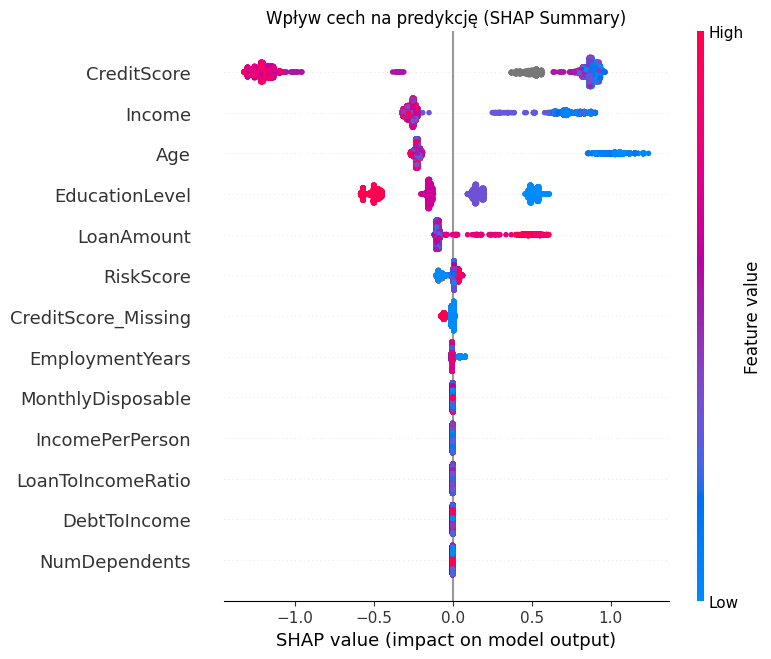

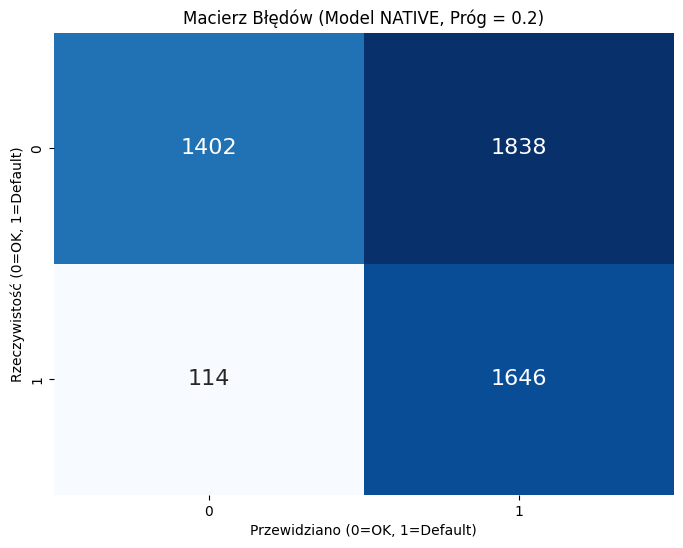

INTERPRETACJA MACIERZY (Próg 0.2):
 Lewy-Góra (TN): 1402 klientów dobrych, których system puścił
 Prawy-Dół (TP): 1646 fraudów/defaultów, które system słusznie zablokował
 Lewy-Dół (FN): 114 fraudów, które nam uciekły
 Prawy-Góra (FP): 1838 dobrych klientów, których zablokowaliśmy niesłusznie


In [57]:
# Wyciągamy wybrany model

best_pipeline_obj = next(p for p in trained_pipelines 
                         if p['scenario'] == 'NATIVE' and p['type'] == 'cat')

model_to_explain = best_pipeline_obj['model']


# Przygotowujemy dane do SHAP
X_shap = X_test_raw.copy()
X_shap = add_features(X_shap, score_col='CreditScore') 

# Wykres SHAP (feature importance)
explainer = shap.TreeExplainer(model_to_explain)
shap_values = explainer.shap_values(X_shap)

plt.figure(figsize=(10, 8))
plt.title("Wpływ cech na predykcję (SHAP)")

# Czerwony - wysoka wartość cechy
# Kropka po prawej stronie - zwiększa ryzyko defaultu
shap.summary_plot(shap_values, X_shap, show=False)
plt.show()

# Confusion matrix dla rekomendowanego progu 0.2
rec_threshold = 0.20

# Generujemy predykcje z wybranego modelu

preds_proba_native = model_to_explain.predict_proba(X_shap)[:, 1]
preds_bin_final = (preds_proba_native >= rec_threshold).astype(int)

cm = confusion_matrix(df_test['Default'], preds_bin_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title(f'Macierz Błędów (Model NATIVE, Próg = {rec_threshold})')
plt.xlabel('Przewidziano (0=OK, 1=Default)')
plt.ylabel('Rzeczywistość (0=OK, 1=Default)')
plt.show()

print(f"INTERPRETACJA MACIERZY (Próg {rec_threshold}):")
print(f" Lewy-Górny (TN): {cm[0][0]} klientów dobrych, których system puścił")
print(f" Prawy-Dolny (TP): {cm[1][1]} fraudów/defaultów, które system słusznie zablokował")
print(f" Lewy-Dolny (FN): {cm[1][0]} fraudów, które nam uciekły")
print(f" Prawy-Górny (FP): {cm[0][1]} dobrych klientów, których zablokowaliśmy niesłusznie")


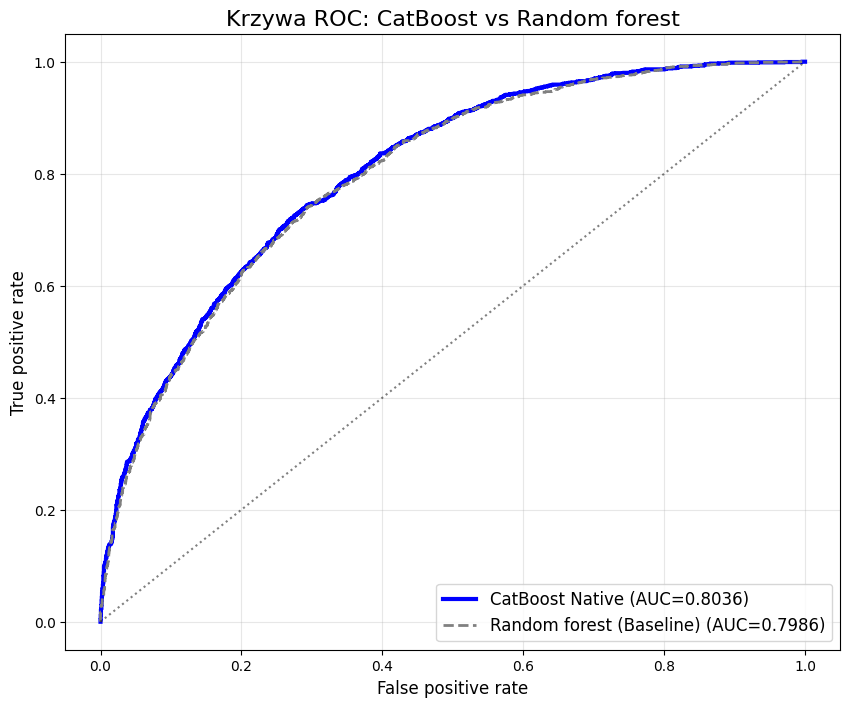

In [19]:
# Porównanie wybranego modelu z random forest

plt.figure(figsize=(10, 8))

# CatBoost 
fpr_cat, tpr_cat, _ = roc_curve(df_test['Default'], avg_test_pred)
auc_cat = roc_auc_score(df_test['Default'], avg_test_pred)
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost Native (AUC={auc_cat:.4f})', color='blue', lw=3)

# Random forest
fpr_rf, tpr_rf, _ = roc_curve(df_test['Default'], rf_pred)
auc_rf = roc_auc_score(df_test['Default'], rf_pred)
plt.plot(fpr_rf, tpr_rf, label=f'Random forest (Baseline) (AUC={auc_rf:.4f})', color='gray', linestyle='--', lw=2)

# Linia losowa
plt.plot([0, 1], [0, 1], 'k:', alpha=0.5)

plt.title('Krzywa ROC: CatBoost vs Random forest', fontsize=16)
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

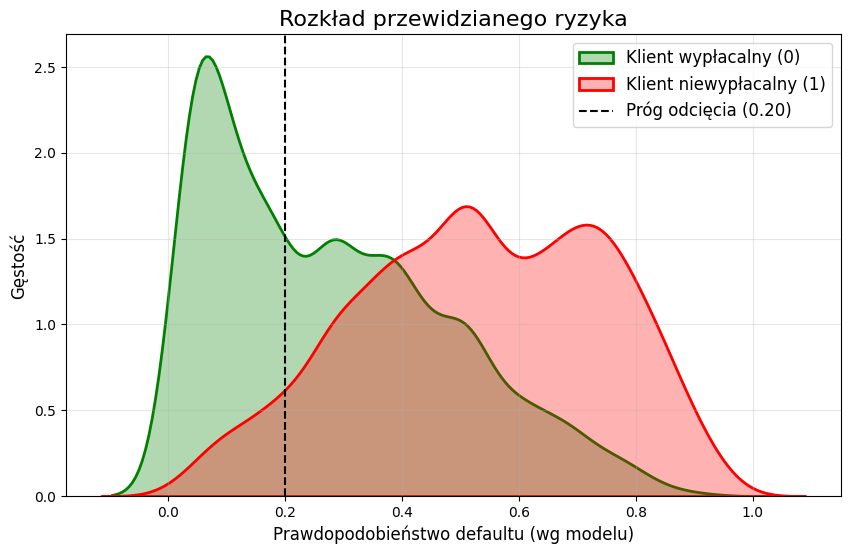

In [24]:
plt.figure(figsize=(10, 6))

# Klasa 0 - spłacił
sns.kdeplot(avg_test_pred[df_test['Default'] == 0], 
            label='Klient wypłacalny (0)', 
            fill=True, color='green', alpha=0.3, linewidth=2)

# Klasa 1 - nie spłacił
sns.kdeplot(avg_test_pred[df_test['Default'] == 1], 
            label='Klient niewypłacalny (1)', 
            fill=True, color='red', alpha=0.3, linewidth=2)

# Linia odcięcia
plt.axvline(0.2, color='black', linestyle='--', label='Próg odcięcia (0.20)')

plt.title('Rozkład przewidzianego ryzyka', fontsize=16)
plt.xlabel('Prawdopodobieństwo defaultu (wg modelu)', fontsize=12)
plt.ylabel('Gęstość', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# zapisujemy model dla dockera
native_model.save_model("catboost_native_credit_v1.cbm")

# Podsumowanie i Wnioski

### 1. Najważniejsze wnioski z analizy
* **Wyższość natywnej obsługi braków:** Model CatBoost trenowany na danych surowych (bez imputacji) osiągnął wyniki zbliżone do złożonych technik ensemblingu, Model osiąga AUC = 0.809, co odpowiada Gini ≈ 0.62
* **Efektywność obliczeniowa:** Wybrany model jest znacznie "lżejszy" i tańszy obliczeniowo w środowisku produkcyjnym niż skomplikowane pipeliny. Pozwala to na szybsze inferencje (scoring w czasie rzeczywistym) i niższe koszty chmury przy zachowaniu wysokiej predykcyjności.
* **Stabilność:** Model wykazuje wysoką stabilność predykcji na zbiorze testowym, co sugeruje odporność na zmianę rozkładu danych w krótkim terminie.
* **Niewielkie różnice pomiędzy modelami:** Z uwagi na bardzo wysoką istotność zmiennej CreditScore różnice pomiędzy stworzonymi modelami a bazowym random forest nie są tak wysokie

### 2. Uzasadnienie podjętych wyborów
* **CatBoost vs Random Forest:** Choć różnica w metrykach (AUC/Gini) między gradient boostingiem a prostszym lasem losowym może wydawać się na papierze niewielka, w skali portfela bankowego ma krytyczne znaczenie.
    * Nawet 0.5-1% różnicy w precyzji przy portfelu tysięcy kredytów przekłada się na zauważalnie większe zyski (lub mniejsze straty na odpisach).
    * Gradient Boosting lepiej wyłapuje nieliniowe zależności w "trudnych" przypadkach, gdzie RF często zawodzi.
* Brak imputacji: Świadomie sprawdziłem czy warto dokonywać imputacji danych. W bankowości *brak danych* to często też informacja (np. klient, który nie podaje stażu pracy, jest bardziej ryzykowny niż ten, który ma 0 lat). CatBoost obsługuje to natywnie, traktując brak jako osobną kategorię/wartość.

### 3. Interpretacja wyników modelu
* **Zarządzanie progiem odcięcia (Threshold):** Model zwraca prawdopodobieństwo (score), ale ostateczna decyzja "daj / nie daj" zależy od macierzy kosztów.
    * Koszt False Negative (udzielenie kredytu, który nie zostanie spłacony) jest wielokrotnie wyższy niż zysk z True Negative (odsetki ze spłaconego kredytu).
    * Dlatego próg odcięcia nie jest sztywnym 0.5, ale został przesunięty (np. na 0.20), aby maksymalizować Recall dla klasy Default.
* **Strategia:** Akceptujemy odrzucenie części dobrych klientów (False Positive), aby zminimalizować ryzyko wpuszczenia do portfela klientów niewypłacalnych.

### 4. Propozycje ulepszeń 

**Zrealizowane usprawnienia inżynierskie:**
* **Konteneryzacja (Docker):** Projekt nie kończy się na notebooku. Model został w pełni **skonteneryzowany** (plik `Dockerfile`).
    * Zapewnia to pełną powtarzalność środowiska.
    * Umożliwia natychmiastowe wdrożenie modelu jako mikroserwisu na platformach orkiestracji (np. Kubernetes, OpenShift) lub w chmurze, co jest standardem w nowoczesnej bankowości.

**Rekomendacje dalszego rozwoju analitycznego:**
1.  **Wzbogacenie danych (Data Enrichment):** Włączenie danych transakcyjnych (PSD2 / Open Banking). Analiza przepływów na koncie daje o wiele lepszy obraz bieżącej płynności klienta niż statyczne dane deklaratywne.
2.  **Dane behawioralne:** Zbieranie metadanych z formularza wniosku (np. dynamika wpisywania danych, poprawki, wklejanie wartości). Są to silne predyktory w modelach antyfraudowych.
2.  **Feature Store:** Wdrożenie centralnego repozytorium cech, aby zagwarantować spójność danych między środowiskiem treningowym a produkcyjnym i uniknąć błędu *training-serving skew*.